The goal of this project is to have a model predict some emotion ratings associated with an image. Pre-trained models will be used on an image set from an emotion study to learn a regression problem.

In [ ]:
#For use if working from Google Colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
#Import Tensorflow packages for modeling
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

#Import optimizer for model
from tensorflow.keras.optimizers import Adam

In [ ]:
#Import packages of metrics for regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import CosineSimilarity

**Set the paths for various paths that will be called on.**

In [ ]:
data_path='../Data/'
img_path='../Images/'
model_path='../Models/'
results_path='../Results/'

In the study, the images were broken up into 6 types.

There were four specific negative content: <br/>
**A:** Animal mistreatment<br/>
**H:** Human rights violation<br/>
**Sn:** Snakes <br/>
**Sp:** Spiders

**Positive** images contain: Human and animal babies, and nature sceneries <br/>
**Neutral** images contain: Inanimate objects


Each image had human ratings on some emotion measures.

In [ ]:
#Reading in all the results from the study
A=pd.read_csv(data_path+'Study Results/A.txt', sep='\t')
H=pd.read_csv(data_path+'Study Results/H.txt', sep='\t')
N=pd.read_csv(data_path+'Study Results/N.txt', sep='\t')
P=pd.read_csv(data_path+'Study Results/P.txt', sep='\t')
Sn=pd.read_csv(data_path+'Study Results/Sn.txt', sep='\t')
Sp=pd.read_csv(data_path+'Study Results/Sp.txt', sep='\t')

In [ ]:
#The same files as above, but with standard deviations for each human-inputted ratings
A_sd=pd.read_csv(data_path+'Study Results/A_with SD.txt', sep='\t')
H_sd=pd.read_csv(data_path+'Study Results/H_with SD.txt', sep='\t')
N_sd=pd.read_csv(data_path+'Study Results/N_with SD.txt', sep='\t')
P_sd=pd.read_csv(data_path+'Study Results/P_with SD.txt', sep='\t')
Sn_sd=pd.read_csv(data_path+'Study Results/Sn_with SD.txt', sep='\t')
Sp_sd=pd.read_csv(data_path+'Study Results/Sp_with SD.txt', sep='\t')

In [ ]:
#Combining results together
df=pd.concat([A,H,N,P,Sn,Sp], axis=0).reset_index(drop=True)

In [ ]:
#Combining the results that has standard deviations together
df_sd=pd.concat([A_sd,H_sd,N_sd,P_sd,Sn_sd,Sp_sd], axis=0).reset_index(drop=True)

In [ ]:
#Check dataframe
df.head()

,Unnamed: 0,Valence,Arousal,Internal norms,External norms
0,A001.jpg,2.553,74.995,12.289429,16.409175
1,A002.jpg,45.698,56.948,75.412445,78.690491
2,A004.jpg,36.197,55.567,40.215111,63.345528
3,A005.jpg,43.439,48.905,51.038688,40.093340
4,A006.jpg,27.544,67.897,22.594799,31.434631


In [ ]:
#Check dataframe with standard deviations
df_sd.head()

,Unnamed: 0,Valence,(SD),Unnamed: 3,Arousal,(SD).1,Unnamed: 6,Internal norms,(SD).2,Unnamed: 9,External norms,(SD).3
0,A001.jpg,2.553,(5.43),NaN,74.995,(22.06),NaN,12.289,(29.83),NaN,16.409,(31.96)
1,A002.jpg,45.698,(16.01),NaN,56.948,(25.21),NaN,75.412,(25.49),NaN,78.690,(22.93)
2,A004.jpg,36.197,(25.63),NaN,55.567,(30.98),NaN,40.215,(40.99),NaN,63.346,(42.37)
3,A005.jpg,43.439,(21.20),NaN,48.905,(31.39),NaN,51.039,(31.79),NaN,40.093,(25.69)
4,A006.jpg,27.544,(16.81),NaN,67.897,(19.94),NaN,22.595,(17.77),NaN,31.435,(29.01)


The dataframe with standard deviations only serves an illustrative purpose to show that ratings for each image vary. If any of the features were to be feature engineered into categorical values, the threshold for determining classes shouldn't be a hard threshold. <br/>
There won't be any further work done using the standard deviation dataframe from this point on.

In [ ]:
#Check shape of dataframe
df.shape

(730, 5)

In [ ]:
#Check out information about the columns in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      730 non-null    object 
 1   Valence         730 non-null    float64
 2   Arousal         730 non-null    float64
 3   Internal norms  229 non-null    float64
 4   External norms  229 non-null    float64
dtypes: float64(4), object(1)
memory usage: 28.6+ KB


Below lists what each numeric column is measuring:

**Valence:** how negative to how positive the image was. 0 = very negative to 100 = very positive, with 50 = neutral.<br/>
i.e: “You are judging this image as …”, from negative to positive. <br/>
**Arousal:** degree of arousal elicited by the picture. <br/>
i.e: “Confronted with this image you are feeling: …”, on two scales: from Calm to Excited, and from Stimulated to Relaxed. <br/>
**Internal norms:** whether the contents of the picture were morally and ethically acceptable (only applicable to animal mistreatment and human rights violation images) <br/>
**External norms:** whether the contents of the picture were legally acceptable (only applicable to animal mistreatment and human rights violation images)

In [ ]:
#Check how many nulls is in each column
df.isna().sum()

Unnamed: 0          0
Valence             0
Arousal             0
Internal norms    501
External norms    501
dtype: int64

Though there are some nulls in the data, the purpose of this project will not be on those measures (internal norms and external norms), so there won't be any dataframe manipulation done to address the nulls.

In [ ]:
#Check for duplicates
df.duplicated().sum()

0

No image have the same ratings, so we don't have to worry about removing images from the dataset.

In [ ]:
#Replacing unnamed column name to file for filename
df=df.rename({'Unnamed: 0':'file'}, axis=1)

In [ ]:
#The extensions of the images were saved as .bmp files
df['file'] = df['file'].str.replace('.jpg','.bmp')

One thing that can be done is to feature engineer the valence scores into classes. Since the study explicity states what types of image fall under which emotional valence category, we can classify the images based on that knowledge rather than from the valence score itself.

In [ ]:
#Create a blank column
df['valence_category']=''
#Assigning class based on emotional valence category associated with each image
for i in range(0,len(df)):
    if df.loc[i, 'file'].startswith('P'): df.loc[i, 'valence_category']='Positive'
    elif df.loc[i, 'file'].startswith('N'): df.loc[i, 'valence_category']='Neutral'
    else: df.loc[i, 'valence_category']='Negative'

In [ ]:
df.head()

,file,Valence,Arousal,Internal norms,External norms,valence_category
0,A001.bmp,2.553,74.995,12.289429,16.409175,Negative
1,A002.bmp,45.698,56.948,75.412445,78.690491,Negative
2,A004.bmp,36.197,55.567,40.215111,63.345528,Negative
3,A005.bmp,43.439,48.905,51.038688,40.093340,Negative
4,A006.bmp,27.544,67.897,22.594799,31.434631,Negative


In [ ]:
#Check how many images are in each category
df['valence_category'].value_counts()

Negative    520
Positive    121
Neutral      89
Name: valence_category, dtype: int64

In [ ]:
#Check size of the subset of images in each category
print(f'Shape of A: {A.shape} \n Shape of H: {H.shape} \n Shape of N: {N.shape} \n Shape of P: {P.shape} \n Shape of Sn: {Sn.shape} \n Shape of Sp: {Sp.shape}')

Shape of A: (124, 5) 
 Shape of H: (105, 5) 
 Shape of N: (89, 3) 
 Shape of P: (121, 3) 
 Shape of Sn: (133, 3) 
 Shape of Sp: (158, 3)


Looking at the number of images by valence interval: <br/>
Although a valence score of 0-49 is considered negative, 50 considered neutral, and 51-100 considered positive, all the image scores have some standard deviation. Thus, there's likely not going to be many images that have an exact score of 50 for example.

Since the range of valence score is from 0-100, it can be divided into 10 bins, with intervals of 10 every bin.

In [ ]:
#First, we need to break the Valence column into intervals, which can be done by using pd.cut, and passing in the bins we want
valence_interval=pd.cut(df['Valence'], bins=[0,10,20,30,40,50,60,70,80,90,100])

#Next, we can group the data by the classes and the valence intervals, and get a count for each class within each interval 
#Which will return a multi-index dataframe
temp_df=df.groupby(['valence_category', valence_interval]).count()
temp_df

file  Valence  ...  Internal norms  External norms
valence_category Valence                    ...                                
Negative         (0, 10]     39.0     39.0  ...            38.0            38.0
                 (10, 20]    95.0     95.0  ...            71.0            71.0
                 (20, 30]    84.0     84.0  ...            44.0            44.0
                 (30, 40]   132.0    132.0  ...            31.0            31.0
                 (40, 50]    96.0     96.0  ...            31.0            31.0
                 (50, 60]    71.0     71.0  ...            13.0            13.0
                 (60, 70]     3.0      3.0  ...             1.0             1.0
                 (70, 80]     NaN      NaN  ...             NaN             NaN
                 (80, 90]     NaN      NaN  ...             NaN             NaN
                 (90, 100]    NaN      NaN  ...             NaN             NaN
Neutral          (0, 10]      NaN      NaN  ...             NaN             NaN
                 (10, 20]     NaN      NaN  ...             NaN             NaN
                 (20, 30]     NaN      NaN  ...             NaN             NaN
                 (30, 40]     NaN      NaN  ...             NaN             NaN
                 (40, 50]    14.0     14.0  ...             0.0             0.0
                 (50, 60]    52.0     52.0  ...             0.0             0.0
                 (60, 70]    23.0     23.0  ...             0.0             0.0
                 (70, 80]     NaN      NaN  ...             NaN             NaN
                 (80, 90]     NaN      NaN  ...             NaN             NaN
                 (90, 100]    NaN      NaN  ...             NaN             NaN
Positive         (0, 10]      NaN      NaN  ...             NaN             NaN
                 (10, 20]     NaN      NaN  ...             NaN             NaN
                 (20, 30]     NaN      NaN  ...             NaN             NaN
                 (30, 40]     NaN      NaN  ...             NaN             NaN
                 (40, 50]     NaN      NaN  ...             NaN             NaN
                 (50, 60]     NaN      NaN  ...             NaN             NaN
                 (60, 70]     NaN      NaN  ...             NaN             NaN
                 (70, 80]    13.0     13.0  ...             0.0             0.0
                 (80, 90]    37.0     37.0  ...             0.0             0.0
                 (90, 100]   71.0     71.0  ...             0.0             0.0

[30 rows x 5 columns]

**Plot the classes based on interval:**

<Figure size 432x288 with 0 Axes>

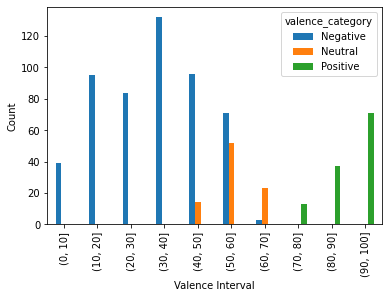

In [ ]:
plt.figure()
#To plot multi-index dataframes, unstack can be used to plot one index with another
#Pass in the Valence column since that's the column of interest
a=temp_df['Valence'].unstack(level=0).plot(kind='bar')
plt.xlabel('Valence Interval')
plt.ylabel('Count')
#plt.savefig(img_path+'Results/Class In Intervals.jpg', bbox_inches='tight')
plt.show()

Look at the range of valence scores in each class to see how differently images under the same category are being rated.

In [ ]:
#Group the dataframe by the valence category, then call on the Valence column to get the score associated with each class
#To get the range of each class, find the minimum and maximum of the valence score within each class
#To call on a specific class, slice the minimum and maximum scores on what class you want to look at
print('Negative range:', df.groupby(['valence_category'])['Valence'].min()['Negative'],
      '-',df.groupby(['valence_category'])['Valence'].max()['Negative'], '\n',
     'Neutral range:', df.groupby(['valence_category'])['Valence'].min()['Neutral'],
      '-',df.groupby(['valence_category'])['Valence'].max()['Neutral'], '\n',
     'Positive range:', df.groupby(['valence_category'])['Valence'].min()['Positive'],
      '-',df.groupby(['valence_category'])['Valence'].max()['Positive'])

Negative range: 0.414 - 63.66 
 Neutral range: 40.953 - 68.85 
 Positive range: 71.86 - 98.73700000000001


Although it seems like a good idea to remove the images that do not fall under the right class based on the valence score, given that the dataset is already very small, it's may be more beneficial to leave the images in. It is also difficult to find open image datasets that have human emotion ratings. 

In [ ]:
#Save results to a csv file to prevent the need to run dataframe manipulation steps every time
df.to_csv(data_path+'Study Results/Summary.csv', index=False)

In [ ]:
#Load previously saved dataset
df=pd.read_csv(data_path+'Study Results/Summary.csv')

## For Regression

**Setting up the regression model:**

In [ ]:
#The images need to be resized to 224 by 224 pixels to have a square image to fit in the pre-trained models,
#and to also cut down on computation time 
width=224
height=224

#There are 3 channels since all the images are color images
channels = 3

def model(model_name):
    #Import the specified pre-trained model, excluding the top layers
    if model_name=='InceptionV3':
        from tensorflow.keras.applications import InceptionV3
        base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(width,height,channels))
    elif model_name=='MobileNet':
        from tensorflow.keras.applications import MobileNet
        base_model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(width,height,channels))
    elif model_name=='ResNet50':
        from tensorflow.keras.applications import ResNet50
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(width,height,channels))
    elif model_name=='VGG19':
        from tensorflow.keras.applications import VGG19
        base_model = VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape=(width,height,channels))
    elif model_name=='Xception':
        from tensorflow.keras.applications import Xception
        base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(width,height,channels))
    else:
        print('Enter valid model name: InceptionV3, MobileNet, ResNet50, VGG19, Xception')
    
    return base_model

In [ ]:
def added_layers(input_model):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.models import Model

    # Create a new model to add the pre-trained model to:
    base_model_out = Sequential()

    # Add the pretrained layers 
    base_model_out.add(input_model)
    
    # Add various numebr dense layers so that the model can learn aspects of our new dataset 
    # and can predict for better results
    #base_model_out.add(Dense(330, activation='relu')) 
    #base_model_out.add(Dropout(0.5))
    
    #base_model_out.add(Dense(100, activation='relu'))
    #base_model_out.add(Dropout(0.5))
    
    base_model_out.add(Dense(27, activation='relu'))
    base_model_out.add(Dropout(0.5))
    #base_model_out.add(BatchNormalization())
    
    base_model_out.add(Dense(27, activation='relu'))
    base_model_out.add(Dropout(0.5))
    
    #base_model_out.add(Dense(5, activation='relu'))
    #base_model_out.add(Dropout(0.5))

    return base_model_out

In [ ]:
#Add the dropouts for each layer to a list
#Will have to be hard-coded to avoid having to call on global variables inside a function
dropout=[0.5,0.5]

In [ ]:
def linear_output(model):
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    #Flatten the data for a linear prediction
    model.add(Flatten())
    
    # Add a final layer with 1 neuron, for a regression prediction, 
    # using a linear activation function:
    model.add(Dense(1, activation='linear'))
    
    return model

Now the model structure has been completed, we can look at a model and it's summary.

In [ ]:
#Pre-trained models: 'InceptionV3', 'MobileNet', 'ResNet50', 'VGG19', 'Xception'
model=model('MobileNet')

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
#Check pre-trained model's summary
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

If training does not go well, or if the model gets stuck at a local minimum, even with hyperparameter optimization, one can opt to unfreeze some pre-trained layers to see if the model's performance will improve.

In [ ]:
# Check the layers in the model in case there is a need to unfreeze some pre-trained layers
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [ ]:
#Setting all layers to not trainable so weights won't be tweaked
#Uncomment [:i] to indicate how many layers to unfreeze from the last layer
for layer in model.layers:#[:i]:
    layer.trainable=False
#for layer in model.layers:#[i:]:
#    layer.trainable=True

#Add layers to model
model=added_layers(model)
#Create linear regression model by adding an output node with a linear activation function
model=linear_output(model)

In [ ]:
#Check new model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 27)                27675     
_________________________________________________________________
dropout (Dropout)            (None, 27)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                756       
_________________________________________________________________
dropout_1 (Dropout)          (None, 27)                0         
_________________________________________________________________
flatten (Flatten)            (None, 27)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [ ]:
#Adjust the preprocess input based on the model used

if model.layers[0].name=='inception_v3':
    model_name='InceptionV3'
elif model.layers[0].name=='mobilenet_1.00_224':
    model_name='MobileNet'
elif model.layers[0].name=='resnet50':
    model_name='ResNet50'
elif model.layers[0].name=='vgg19':
    model_name='VGG19'
elif model.layers[0].name=='xception':
    model_name='Xception'
else:
    print('Check model\'s layers')

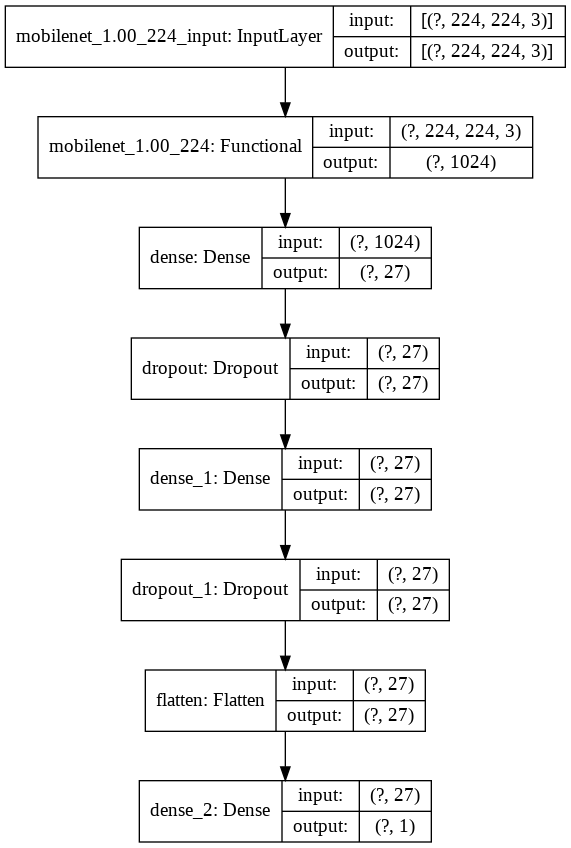

In [ ]:
#Save the model's architecture to an image
plot_model(model, 
           to_file='{}{}/{} Regression Model Plot.png'.format(img_path, model_name, model_name), 
           show_shapes=True, 
           show_layer_names=True)

In [ ]:
#Save the number of nodes in each newly added layer into a list
nodes=[]
count=0
#Get the layers between the pre-trained layers and the last flatten and output layer
for layer in model.layers[1:-2]:
    #This can be set to include other types other layers such as Conv2D or LTSM layers, etc.
    if  layer.__class__.__name__=='Dense':
        nodes.append(layer.output_shape[1])
    else: 
        pass

**Create the train and test datasets:**

In [ ]:
#Adjust the preprocess input based on the model used

if model_name=='InceptionV3':
    from tensorflow.keras.applications.inception_v3 import preprocess_input
elif model_name=='MobileNet':
    from tensorflow.keras.applications.mobilenet import preprocess_input
elif model_name=='ResNet50':
    from tensorflow.keras.applications.resnet50 import preprocess_input
elif model_name=='VGG19':
    from tensorflow.keras.applications.vgg19 import preprocess_input
elif model_name=='Xception':
    from tensorflow.keras.applications.xception import preprocess_input
else:
    print('Check model name')

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

When doing a validation split using ImageDataGenerator, the flow_from_dataframe will not randomize the train and validation split. Thus the dataframe images are being generated from, needs to be randomized.

In [ ]:
#To randomize the rows in the original dataframe, use the .sample() method
#Pass frac=1 as argument to have the entire dataframe randomized
df=df.sample(frac=1).reset_index(drop=True)

**Create train and test dataframes:**

In [ ]:
#Get a list of files that are in each category
train_pos=os.listdir(data_path+'train/Positive')
train_neut=os.listdir(data_path+'train/Neutral')
train_neg=os.listdir(data_path+'train/Negative')

#Filter the dataset based on the files in each category
train_df=df[(df['file'].isin(train_pos)) | (df['file'].isin(train_neut)) | (df['file'].isin(train_neg))]
train_df.reset_index(drop=True, inplace=True)

#Rename the filenames for generating the images from the train directory later
for i in range(len(train_df)):
    if train_df.loc[i, 'file'] in str(train_pos):
        train_df.loc[i, 'file']="Positive/"+train_df.loc[i, 'file']
    if train_df.loc[i, 'file'] in str(train_neg):
        train_df.loc[i, 'file']="Negative/"+train_df.loc[i, 'file']
    if train_df.loc[i, 'file'] in str(train_neut):
        train_df.loc[i, 'file']="Neutral/"+train_df.loc[i, 'file']
        
#Get a list of files that are in each category
test_pos=os.listdir(data_path+'test/Positive')
test_neut=os.listdir(data_path+'test/Neutral')
test_neg=os.listdir(data_path+'test/Negative')

#Filter the dataset based on the files in each category
test_df=df[(df['file'].isin(test_pos)) | (df['file'].isin(test_neut)) | (df['file'].isin(test_neg))]
test_df.reset_index(drop=True, inplace=True)

#Rename the filenames for generating the images from the test directory later
for i in range(len(test_df)):
    if test_df.loc[i, 'file'] in str(test_pos):
        test_df.loc[i, 'file']="Positive/"+test_df.loc[i, 'file']
    if test_df.loc[i, 'file'] in str(test_neg):
        test_df.loc[i, 'file']="Negative/"+test_df.loc[i, 'file']
    if test_df.loc[i, 'file'] in str(test_neut):
        test_df.loc[i, 'file']="Neutral/"+test_df.loc[i, 'file']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
#Save results to a csv file to prevent the need to run dataframe manipulation steps every time
#train_df.to_csv(data_path+'Study Results/Train Set.csv', index=False)
#test_df.to_csv(data_path+'Study Results/Test Set.csv', index=False)

In [ ]:
#Load previously saved dataframe
train_df=pd.read_csv(data_path+'Study Results/Train Set.csv')
test_df=pd.read_csv(data_path+'Study Results/Test Set.csv')

Setting the test set to have a batch size equal to the test sample size. This ensures that each image is considered and will have a predicted value when the model updates it's weights (batch gradient descent). This will not cost too much resources for image sets that aren't very large.

In [ ]:
#Set batch size
batch_size=32

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=data_path+"train",
                                                    x_col="file",
                                                    y_col="Valence", 
                                                    class_mode="raw", 
                                                    target_size=(width, height),
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    shuffle=True)
validation_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                         directory=data_path+"train",                                           
                                                         x_col="file", 
                                                         y_col="Valence",                                               
                                                         class_mode="raw", 
                                                         target_size=(width, height), 
                                                         batch_size=batch_size,
                                                         subset='validation',
                                                         shuffle=False)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=data_path+"test", 
                                                  x_col="file", 
                                                  y_col="Valence",  
                                                  class_mode="raw", 
                                                  target_size=(width, height),                                           
                                                  batch_size=145,
                                                  shuffle=True)

Found 468 validated image filenames.
Found 117 validated image filenames.
Found 145 validated image filenames.


In [ ]:
#Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 
valid_stepsize = validation_generator.samples//validation_generator.batch_size 
test_stepsize = test_generator.samples//test_generator.batch_size 

#Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize} \nTest step size = {test_stepsize}')

Training step size = 14 
Validation step size = 3 
Test step size = 1


Now that the model structure and datasets are ready, we can define the other parameters the model will call on.

In [ ]:
#Set hyperparameters

#Set epochs
epoch=150

#Set callback to true if early stopping is included during training,
#And false if not using early stopping
callback=False

#Making sure that early stopping only happens when callback is set to True
if callback==True:
    #Set patience for early stopping
    pat=50
    #Initiate early stop based on validation loss
    ES=EarlyStopping(monitor='val_loss', patience=pat, mode='auto', min_delta=0.0001, verbose=1)
else:
    #Set early stop to a string, which will return an error when fitting the model
    ES='Undefined'

#Set learning rate
learning_rate=0.000075
#Instantiate optimizer with pre-defined learning rate
optim = Adam(lr=learning_rate)

#Set the loss metric used to evaluate model performance
loss_function='mean_squared_error'

In [ ]:
#Compile model
model.compile(optimizer=optim,
              loss=loss_function,
              metrics=['mae', 'mape', 'cosine_similarity'])

In [ ]:
#Fit model
if callback==True:
    history = model.fit(x=train_generator, 
                    steps_per_epoch=train_stepsize,
                    validation_data=validation_generator,
                    validation_steps=valid_stepsize,
                    callbacks=[ES],
                    epochs = epoch)
elif callback==False:
    history = model.fit(x=train_generator, 
                    steps_per_epoch=train_stepsize,
                    validation_data=validation_generator,
                    validation_steps=valid_stepsize,
                    #callbacks=[ES],
                    epochs = epoch)
else:
    print('Set proper callback value')

Epoch 1/150
14/14 [==============================] - 168s 12s/step - loss: 2462.9031 - mae: 43.1864 - mape: 95.8403 - cosine_similarity: 0.6055 - val_loss: 2429.8767 - val_mae: 41.9835 - val_mape: 92.4664 - val_cosine_similarity: 1.0000
Epoch 2/150
14/14 [==============================] - 2s 141ms/step - loss: 2388.3381 - mae: 41.9822 - mape: 91.3413 - cosine_similarity: 0.8624 - val_loss: 2341.0334 - val_mae: 40.8683 - val_mape: 87.9726 - val_cosine_similarity: 1.0000
Epoch 3/150
14/14 [==============================] - 2s 145ms/step - loss: 2234.1995 - mae: 40.5420 - mape: 89.4157 - cosine_similarity: 0.8853 - val_loss: 2240.7927 - val_mae: 39.6098 - val_mape: 83.7091 - val_cosine_similarity: 1.0000
Epoch 4/150
14/14 [==============================] - 2s 143ms/step - loss: 2179.7722 - mae: 39.5950 - mape: 87.1285 - cosine_similarity: 0.8884 - val_loss: 2131.2554 - val_mae: 38.1776 - val_mape: 78.9030 - val_cosine_similarity: 1.0000
Epoch 5/150
14/14 [==============================] -

In [ ]:
#Save results of whether the model stopped training early or not, 
#or assign early stop and patience to N/A if callback was not assigned 
if callback==True:
    if len(history.history['loss'])==epoch:
        early_stop='F'
    else:
        early_stop='T, epoch {}'.format(len(history.history['loss']))
else:
    early_stop='N/A'
    pat='N/A'

In [ ]:
#Save the metrics result of the last epoch ran to a list
metrics=[]
for i in history.history:
    metrics.append({i:history.history[i][-1]})

#Train loss, round to 3 decimal places
loss=round(metrics[0].get('loss'),3)
#Other metrics measured
other_metrics=metrics[1:]

Creating a dataframe to store results of train and validation loss per epoch:

In [ ]:
'''
#For first time run-through only

#Create empty dataframes
train_loss_per_epoch=pd.DataFrame()
val_loss_per_epoch=pd.DataFrame()

#Creating a column name for the specific model that was ran
title='{} Dense layers, Nodes: {}, Dropout: {}, Learning rate: {}, Loss function: {}, \
Epochs: {}, Early stop: {}, Stop patience: {}\
'.format(len(nodes), nodes, dropout, learning_rate, loss_function, epoch, early_stop, pat)

#Insert loss per epoch into the dataframe based it's model's parameters
train_loss_per_epoch.insert(0,title,history.history['loss'])
val_loss_per_epoch.insert(0,title,history.history['val_loss'])
'''

In [ ]:
#Load previously saved train and validation loss dataframe
train_loss_per_epoch=pd.read_csv('{}{}/{} Regression Train Loss per Epoch.csv'.format(results_path, model_name, model_name))
val_loss_per_epoch=pd.read_csv('{}{}/{} Regression Validation Loss per Epoch.csv'.format(results_path, model_name, model_name))

Since the loss results of every run is being saved into the same dataframe, if a model ran for a different epoch than from the existing data, the results will be of different lengths. In this case, trying to save the result to the same dataframe will result in an error. So, a temporary dataframe is needed to store the results, then combine it with the original dataframe, and fill in the nulls with 0 so that the results can be plotted. <br/>
The important thing is to mention what is happening when the loss suddenly drops down to 0, whether that's due to early stopping or due to different epochs.

Alternatively, one can create dataframes for certain set amount of epochs. One thing to note is that this could result in multiple files. 

In [ ]:
#Create a column name for the specific parameters that was tested
title='{} Dense layers, Nodes: {}, Dropout: {}, Learning rate: {}, Loss function: {}, \
Epochs: {}, Early stop: {}, Stop patience: {}\
'.format(len(nodes), nodes, dropout, learning_rate, loss_function, epoch, early_stop, pat)

#Create temporary dataframes to store results to, as results of different lengths cannot be stored together
temp_train_loss_df=pd.DataFrame()
temp_val_loss_df=pd.DataFrame()
temp_train_loss_df.insert(0,title,history.history['loss'])
temp_val_loss_df.insert(0,title,history.history['val_loss'])

#Combine the new results with old dataset
#Use fillna(0) to patch up any missing values with 0 for runs of different lengths
train_loss_per_epoch=pd.concat([temp_train_loss_df, train_loss_per_epoch], axis=1).fillna(0)
val_loss_per_epoch=pd.concat([temp_val_loss_df, val_loss_per_epoch], axis=1).fillna(0)

In [ ]:
#Save train and validation loss datasets to csv files
train_loss_per_epoch.to_csv('{}{}/{} Regression Train Loss per Epoch.csv'.format(results_path, model_name, model_name), index=False)
val_loss_per_epoch.to_csv('{}{}/{} Regression Validation Loss per Epoch.csv'.format(results_path, model_name, model_name), index=False)

Once a model has been saved, it can be loaded without having re-run the fitting and training. The code for saving the model is found further down below.

In [ ]:
#Load previously saved model
#Model names: 'InceptionV3', 'MobileNet', 'ResNet50', 'VGG19', 'Xception'
#model_name=''

model=load_model('{}{}/{} MSE model.h5'.format(model_path, model_name, model_name))

In [ ]:
#Get predictions on test data and save to a variable
test_preds=model.predict(x=test_generator, steps=1)

#Reshape the true y-values to match the shape of test_preds
test_true=np.array(test_df['Valence']).reshape(-1,1)

The metrics used here are the $R^2$ score and and mean squared error. The $R^2$ score indicates how close the datapoints are to the predicted regression line. The goal is to get the $R^2$ score between 0 and +1, and to get it as close to positive 1 as possible. The mean squared error indicates how different the predicted values and the true values are. The goal of the mean squared error is to get the score as close to 0 as possible.

In [ ]:
#Evaluate the R^2 score of the model
test_r2=r2_score(test_true,test_preds)
#Evaluate the MSE on the test data
test_mse=mean_squared_error(test_true,test_preds)

print(f'Test R^2: {round(test_r2,3)}, MSE: {round(test_mse,3)}')

Test R^2: -0.34, MSE: 897.312


Plot what the model is predicting versus what the true values actually are.

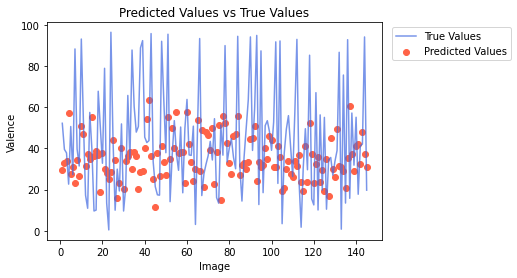

In [ ]:
plt.figure()
#The range starts at 1 since epochs start at 1, and add 1 to the length of the run as np.arange stops exclusive
plt.plot(np.arange(1,len(test_true)+1), test_true, label='True Values', color='royalblue', alpha=0.7)
plt.scatter(np.arange(1,len(test_preds)+1), test_preds, label='Predicted Values', color='tomato')
plt.xlabel('Image')
plt.ylabel('Valence')
plt.title('Predicted Values vs True Values')

#Save the figure before displaying it, specify bbox_inches to get rid of extra white spaces
#plt.savefig('{}{}/{} Regression Pred vs True Regression.jpg'.format(img_path, model_name, model_name), bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()

An important thing to remember to do is to save the results of the run to keep track of hyperparameter optimization. 

In [ ]:
'''
#Create a result dataframe to save testing information to (first time only), 
#then load the previously saved results to avoid overwriting saved data.
results_df=pd.DataFrame(columns=['model', 'new layers before flatten', 'nodes', 'dropout', 'lr', 'loss function', 'train_loss', 'other metrics', 'test_MSE', 'test_R2', 'epochs', 'early_stopping', 'stop_patience'])
'''

In [ ]:
#Load the previously saved results for further testing
results_df=pd.read_csv('{}{}/{} Regression Optimization.csv'.format(results_path, model_name, model_name))

In [ ]:
#Save results of optimization into dataframe
results_df=results_df.append(pd.Series({'model': model_name, 
                                        'new layers before flatten': len(model.layers[1:-2]), 
                                        'nodes': nodes, 
                                        'dropout': dropout, 
                                        'lr': learning_rate, 
                                        'loss function': loss_function, 
                                        'train_loss': loss, 
                                        'other metrics': other_metrics, 
                                        'test_MSE': test_mse, 
                                        'test_R2': test_r2, 
                                        'epochs': epoch, 
                                        'early_stopping': early_stop, 
                                        'stop_patience': pat}), ignore_index=True)

In [ ]:
results_df.head()

,model,new layers before flatten,nodes,dropout,lr,loss function,train_loss,other metrics,test_MSE,test_R2,epochs,early_stopping,stop_patience
0,MobileNet,5,"[28, 5]","[0.3, 0.3]",0.000080,mean_squared_error,588.269,"[{'mae': 18.6601619720459}, {'mape': 88.542747...",814.492553,-0.216077,100,F,50.0
1,MobileNet,7,"[350, 300, 75, 15]","[0.5, 0.5, 0.5, 0]",0.000080,mean_squared_error,179.754,"[{'mae': 10.53239917755127}, {'mape': 42.76624...",1072.141784,-0.600760,150,"T, epoch 93",50.0
2,MobileNet,8,"[200, 100, 50, 28]","[0.5, 0.5, 0.5, 0.5]",0.000050,mean_squared_error,675.705,"[{'mae': 20.29682731628418}, {'mape': 65.31738...",962.894692,-0.437649,150,F,50.0
3,MobileNet,6,"[30, 30, 30]","[0.5, 0.5, 0.5]",0.000050,mean_squared_error,913.825,"[{'mae': 24.04484748840332}, {'mape': 90.32450...",966.038502,-0.442343,150,F,50.0
4,MobileNet,1,[28],[0],0.000075,mean_squared_error,160.538,"[{'mae': 9.957844734191895}, {'mape': 54.29346...",933.179302,-0.393282,250,NaN,NaN
5,MobileNet,4,"[32, 32]","[0.5, 0.5]",0.000075,mean_squared_error,412.701,"[{'mae': 15.733777046203613}, {'mape': 70.3169...",901.931289,-0.346627,250,F,50.0
6,MobileNet,4,"[29, 4]","[0.5, 0.5]",0.000075,mean_squared_error,1266.196,"[{'mae': 27.653003692626953}, {'mape': 88.0990...",1117.648769,-0.668704,300,F,50.0
7,MobileNet,4,"[27, 27]","[0.5, 0.5]",0.000075,mean_squared_error,678.541,"[{'mae': 20.31023406982422}, {'mape': 83.34676...",795.873587,-0.188278,150,NaN,NaN


In [ ]:
#Save results as a csv file
results_df.to_csv('{}{}/{} Regression Optimization.csv'.format(results_path, model_name, model_name), index=False)

In [ ]:
#Save model for future calls if it performed better than previous models
if len(results_df)!=1:
    if test_mse < results_df['test_MSE'].min():
        model.save('{}{}/{} MSE model.h5'.format(model_path, model_name, model_name))
    else:
        pass
#If this is the first run, save the model 
else:
    model.save('{}{}/{} MSE model.h5'.format(model_path, model_name, model_name))

**To visualize the change in loss over epochs.** <br/>
There's a couple of ways to do this:

One way is to plot the training and validation loss per epoch on two separate graphs. This allows for the comparison of different parameter settings on one graph for training loss and one graph for validation loss.

Another way is to graph the training and validation loss for each parameter setting on the same graph to compare when the model starts overfitting. This will mean that there will be one graph for each parameter setting of the model.

The last way is to graph multiple models with the same parameter settings on one graph. Multiple models referring to different CNN models that have different pre-trained weights and architecture, and the same parameter settings only applies for layers added on to the pre-trained models. This allows for comparison of which model performs the best given some parameter setting.

**Things to note:** <br/>
If the scale of loss function value vary drastically across different runs of the model, then plotting all the loss per epoch on the same graph may not be meaningful. One may consider plotting the loss per epoch based on range instead.

Another thing to note is it may better to graph based on epochs ran. However, if there are runs that differ drastically in terms of epochs, such as 20 vs 100, it may be better to plot the loss by intervals, such as by every 100 epoch. Change the titles of the plots accordingly.

In [ ]:
#Getting the model results to plot
#Using sorted allows the runs to be plotted from least to most dense layers, since dense layers is the first column
trained_models=sorted(train_loss_per_epoch.columns)
valid_models=sorted(val_loss_per_epoch.columns)

Create a separate plot for training and validation loss:

<Figure size 432x288 with 0 Axes>

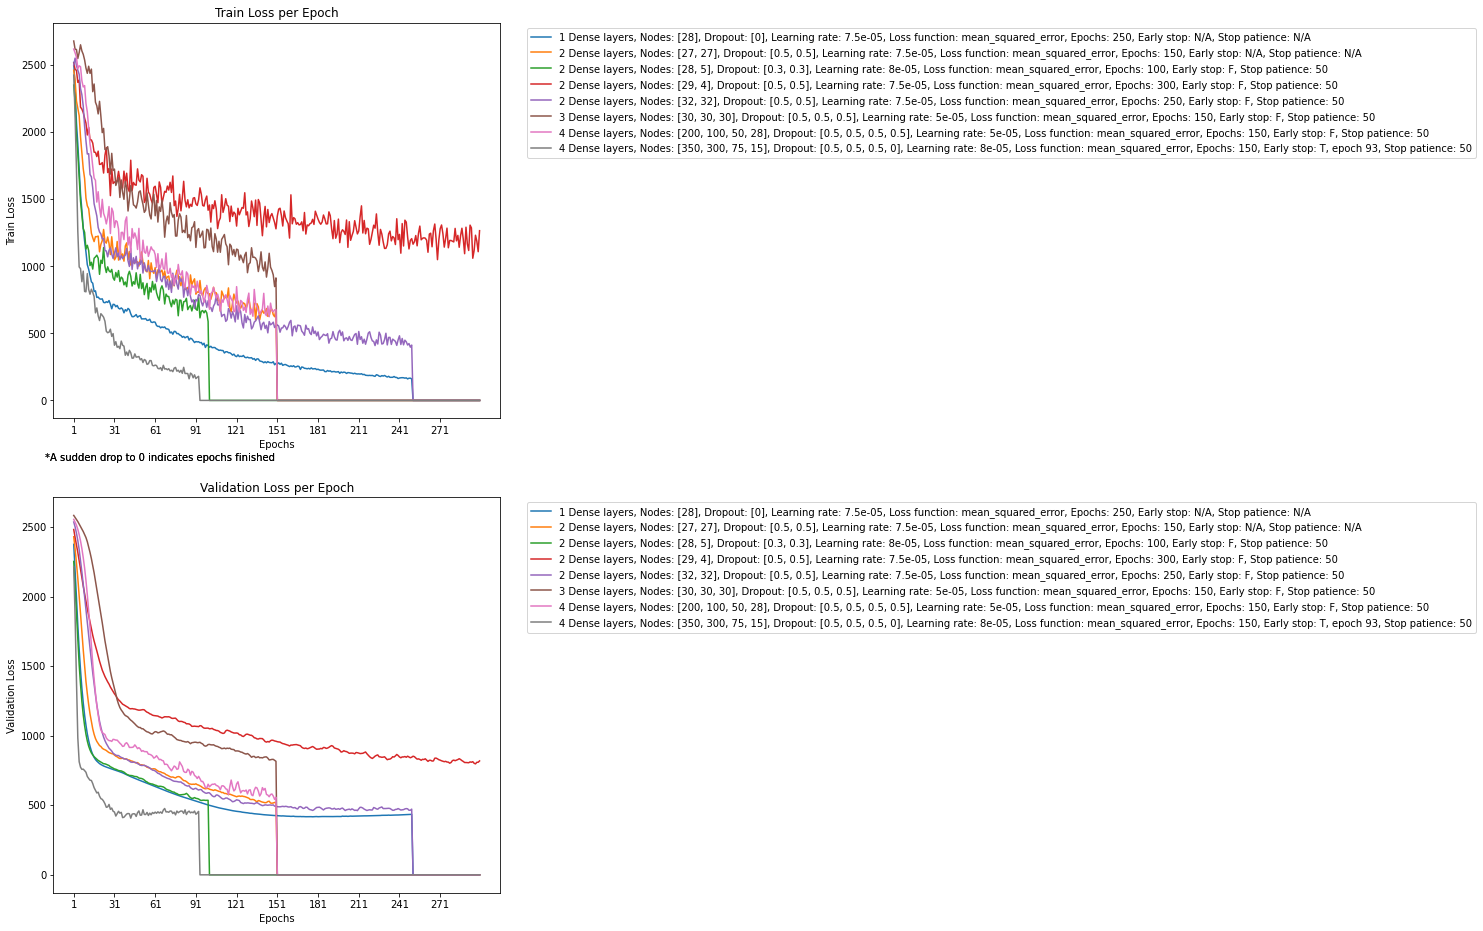

In [ ]:
plt.figure()
#Create a plot for train and validation loss per epoch
plt.subplots(2,1, figsize=(8,16))

plt.subplot(2,1,1)

# Loop through the model results and plot them on one graph
# If there's too many models, consider slicing the columns into multiple variables and making multiple plots
for model in trained_models:
    train_epoch_len=len(train_loss_per_epoch[model])
    # Plot the model results based on how many epochs were ran, in case of early stopping
    plt.plot(np.arange(1, train_epoch_len+1),#[0:100], #Modify x-range based on epoch/interval by slicing
             train_loss_per_epoch[model],#[0:100], #Pass in the epoch or interval to look at by slicing; e.g: [model][0:100]
             label=model) #Set the label as the model to refer to results of different parameter settings
plt.xlabel('Epochs')
# Change tick step size depending on how much epochs is ran
plt.xticks(np.arange(1, train_epoch_len+1, step=int(round(0.1*train_epoch_len))))#[0:100]) #Modify x-ticks range based on epoch/interval
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
#Add footnote to plot by passing in transform=plt.gcf() to get the figure, 
#And use transFigure to move the text by coordinates: (0,0) is bottom left and (1,1) is top right
plt.text(0.11,0.5,'*A sudden drop to 0 indicates epochs finished', transform=plt.gcf().transFigure)
# Use bbox_to_anchor to resize legend, and use loc to indicate location of legend
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(2,1,2)
for model in valid_models:
    val_epoch_len=len(val_loss_per_epoch[model])
    plt.plot(np.arange(1, val_epoch_len+1),#[0:100], 
             val_loss_per_epoch[model],#[0:100], 
             label=model)
plt.xlabel('Epochs')
plt.xticks(np.arange(1, val_epoch_len+1, step=int(round(0.1*val_epoch_len))))#[0:100])
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.text(0.11,0.5,'*A sudden drop to 0 indicates epochs finished', transform=plt.gcf().transFigure)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#Save the figure before displaying it, specify bbox_inches to get rid of extra white spaces
plt.savefig('{}{}/{} Regression Parameter Loss.jpg'.format(img_path, model_name, model_name), bbox_inches='tight')
plt.show()

Create a plot for each model run with training and validation loss on the same plot:

<Figure size 432x288 with 0 Axes>

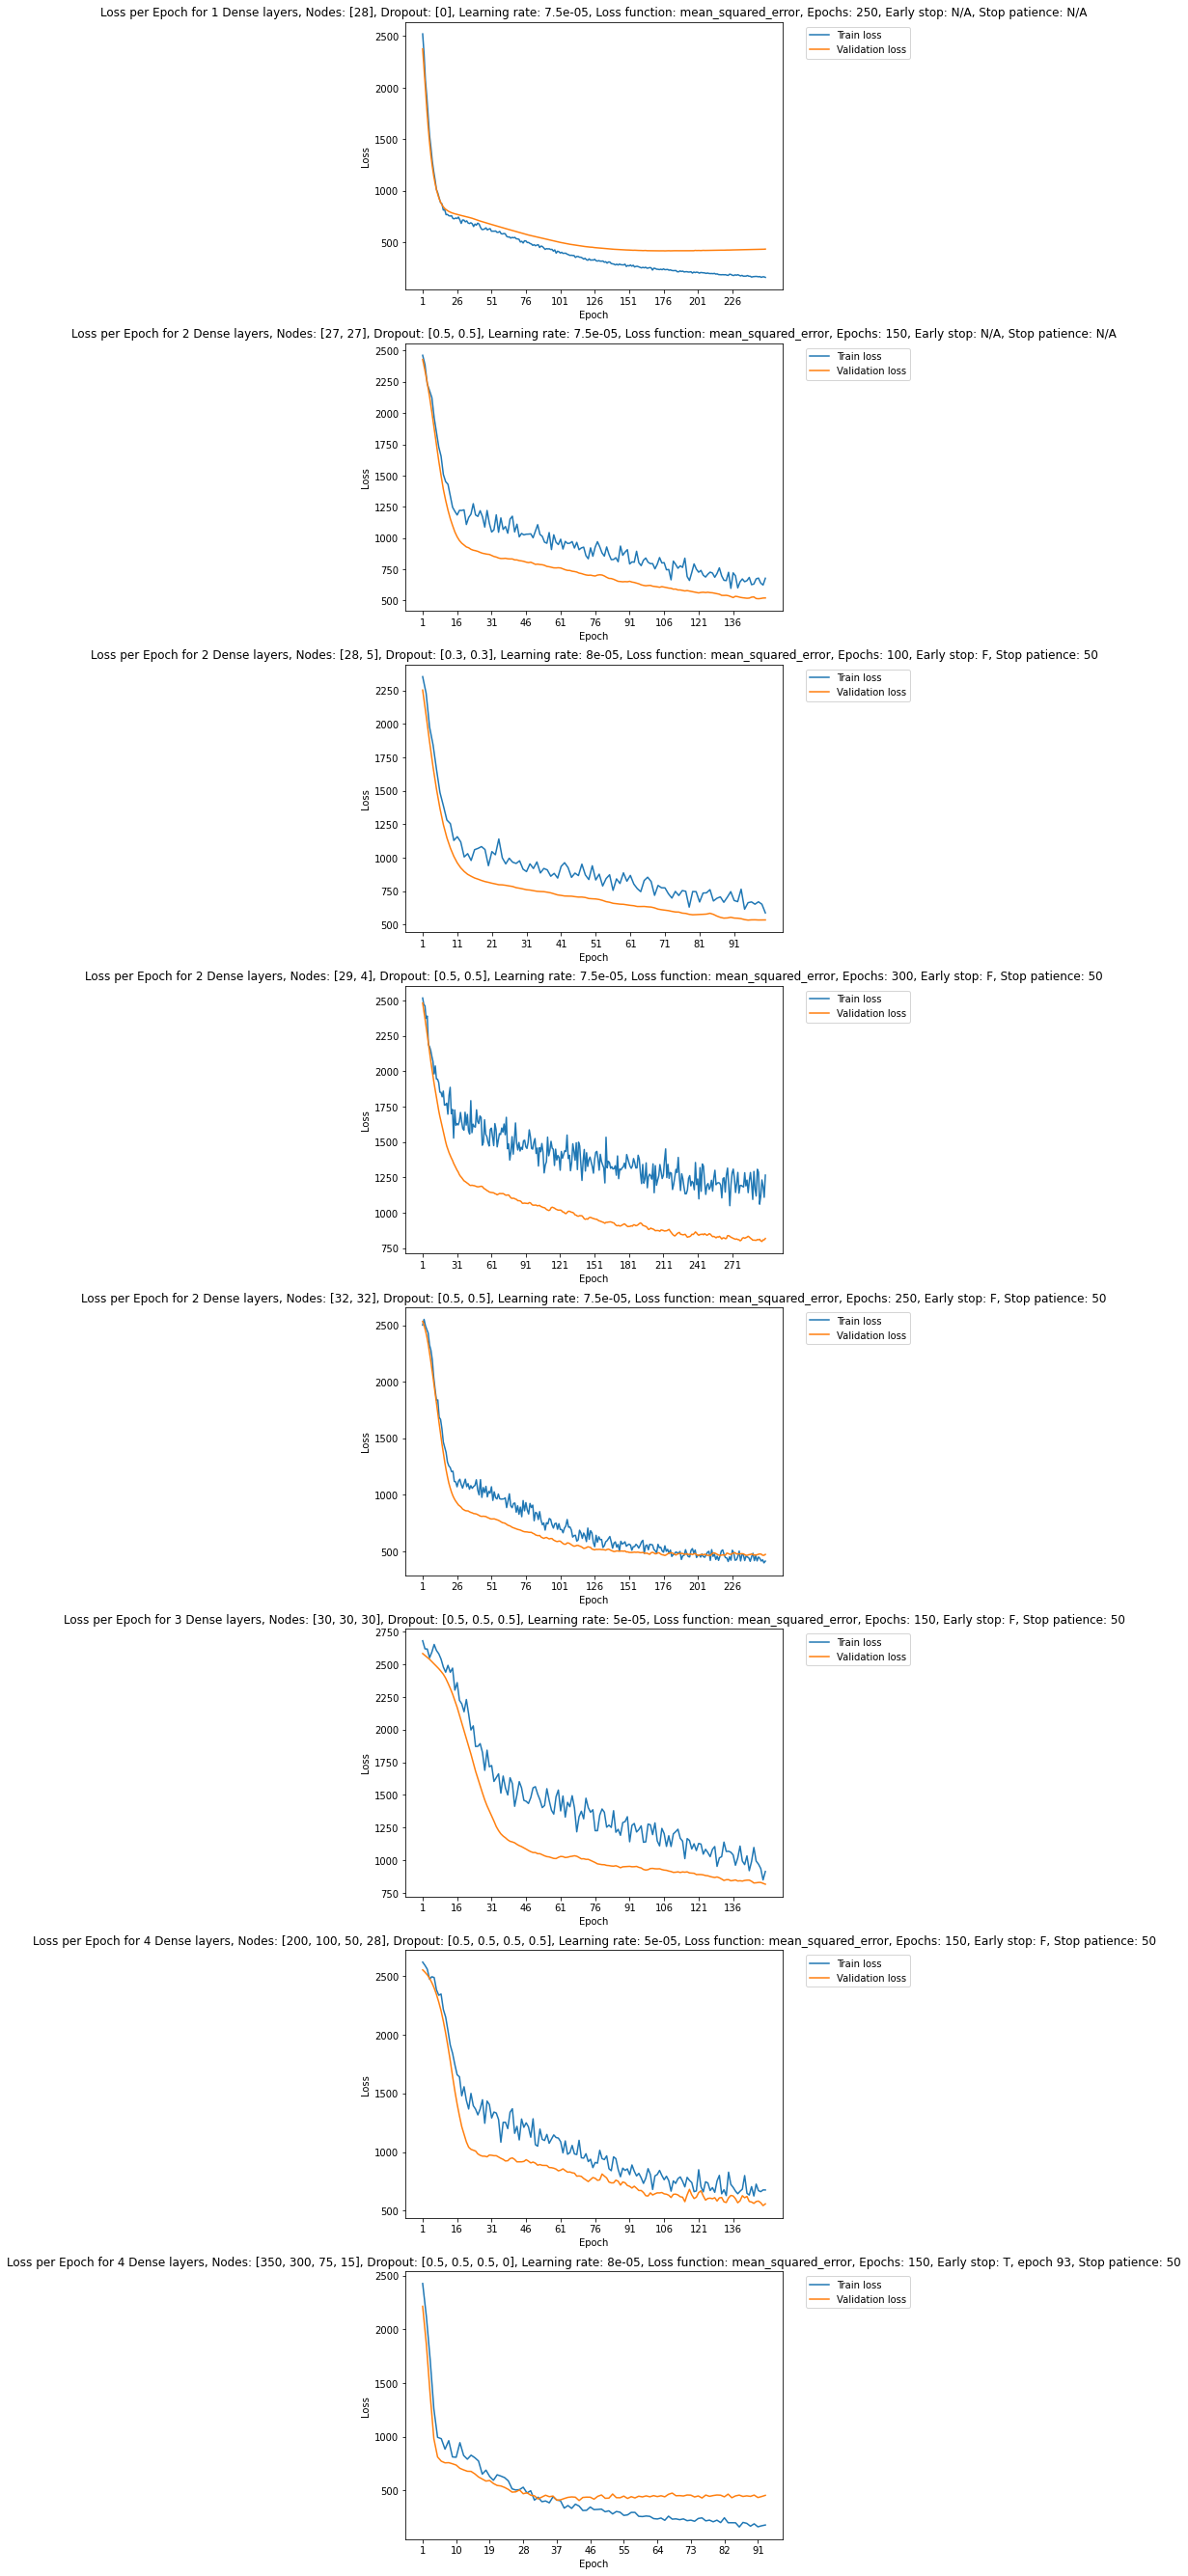

In [ ]:
n=len(trained_models)
plt.figure()
# Create a plot for train and validation loss per epoch
# figsize needs to be adjusted depending on how many plots there are
plt.subplots(n, 1, figsize=(7,n*6))

# Loop through the model results and create a plot for every run
for i in range(1, n+1):
    #Getting the length of each run by filtering out the NaNs that were replaced by 0s
    train_len=train_loss_per_epoch[trained_models[i-1]].astype(bool).sum()
    val_len=val_loss_per_epoch[valid_models[i-1]].astype(bool).sum()
    
    plt.subplot(n,1,i)
    # If there's too many models, consider slicing the columns into multiple variables and making multiple calls
    # Plot the model results based on how many epochs were ran, in case of early stopping
    plt.plot(np.arange(1, train_len+1), 
             train_loss_per_epoch[trained_models[i-1]][0:train_len], 
             label='Train loss')
    plt.plot(np.arange(1, val_len+1), 
             val_loss_per_epoch[valid_models[i-1]][0:val_len], 
             label='Validation loss')
    
    plt.xlabel('Epoch')
    # Change tick step size depending on how much epochs is ran
    plt.xticks(np.arange(1, train_len+1, step=int(round(0.1*train_len)))) #Modify x-range based on epoch/interval
    plt.ylabel('Loss')
    plt.title('Loss per Epoch for '+trained_models[i-1])
    # Use bbox_to_anchor to resize legend and loc to move it outside the plot figure
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Save the figure before displaying it, specify bbox_inches to get rid of extra white spaces
plt.savefig('{}{}/{} Regression Train+Valid Loss.jpg'.format(img_path, model_name, model_name), bbox_inches='tight')
plt.show()

## For Classification

**Make simple classification model:**

In [ ]:
#Import necessary packages for simple classification
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
#Import necessary packges for classifcation model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**Loading in previously saved data sets:**

In [ ]:
#Load previously saved dataframe
train_df=pd.read_csv(data_path+'Study Results/Train Set.csv')
test_df=pd.read_csv(data_path+'Study Results/Test Set.csv')

In [ ]:
#Model names: 'InceptionV3', 'MobileNet', 'ResNet50', 'VGG19', 'Xception
model_name=''

#Load previously saved model
model=load_model('{}{}/{} MSE model.h5'.format(model_path, model_name, model_name))

In [ ]:
if model.layers[0].name=='inception_v3':
    from tensorflow.keras.applications.inception_v3 import preprocess_input
    model_name='InceptionV3'
elif model.layers[0].name=='mobilenet_1.00_224':
    from tensorflow.keras.applications.mobilenet import preprocess_input
    model_name='MobileNet'
elif model.layers[0].name=='resnet50':
    from tensorflow.keras.applications.resnet50 import preprocess_input
    model_name='ResNet50'
elif model.layers[0].name=='vgg19':
    from tensorflow.keras.applications.vgg19 import preprocess_input
    model_name='VGG19'
elif model.layers[0].name=='xception':
    from tensorflow.keras.applications.xception import preprocess_input
    model_name='Xception'
else:
    print('Check model\'s layers')

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Setting batch size each to size of data set so each image has a predicted value.

In [ ]:
#The images need to be resized to 224 by 224 pixels to have a square image to fit in the pre-trained models,
#and to also cut down on computation time 
width=224
height=224

#Reading in the train set without a validation set
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=data_path+"train", 
                                                    x_col="file", 
                                                    y_col="Valence", 
                                                    class_mode="raw", 
                                                    target_size=(width, height), 
                                                    batch_size=585,
                                                    shuffle=True)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=data_path+"test", 
                                                  x_col="file", 
                                                  y_col="Valence", 
                                                  class_mode="raw", 
                                                  target_size=(width, height),                                           
                                                  batch_size=145,
                                                  shuffle=True)

Found 585 validated image filenames.
Found 145 validated image filenames.


In [ ]:
#Although it seems counter-intuitive to have a model predict values for its train data,
#This is meant to generate training data for the classification model to learn from
X_train=model.predict(x=train_generator, steps=1)
y_train=train_df['valence_category']
X_test=model.predict(x=test_generator, steps=1)
y_test=test_df['valence_category']

In [ ]:
#Creating the pipeline for hyperparameter optimization
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
{'model': [LogisticRegression()], 
'normalise': [StandardScaler(), None],
'model__C': [0.00001,0.0001,0.001,0.1,1,10,100,1000]}]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
fitted_grid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.9s finished


In [ ]:
#Get the best accuracy score
fitted_grid.score(X_test, y_test)

0.7172413793103448

In [ ]:
#Get the best model
fitted_grid.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1e-05, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
#Get the best parameter settings
fitted_grid.best_params_

{'model': LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'model__C': 1e-05,
 'normalise': StandardScaler(copy=True, with_mean=True, with_std=True)}

Look at the precision and recall score for each class.

In [ ]:
#Generate predictions for the test set
y_preds=fitted_grid.predict(X_test)

In [ ]:
#Check the precision and recall
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

    Negative       0.72      1.00      0.84       104
     Neutral       0.00      0.00      0.00        17
    Positive       0.00      0.00      0.00        24

    accuracy                           0.72       145
   macro avg       0.24      0.33      0.28       145
weighted avg       0.51      0.72      0.60       145



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Check for false positives and negatives by looking at what class images are being predicted as.

In [ ]:
#Use a confusion matrix to see predictions for each class
test_matrix=pd.DataFrame(confusion_matrix(y_test,y_preds),
            index = ['True Negative','True Neutral','True Positive'],
            columns =  ['Predicted Negative','Predicted Neutral','Predicted Positive'])
test_matrix

,Predicted Negative,Predicted Neutral,Predicted Positive
True Negative,104,0,0
True Neutral,17,0,0
True Positive,24,0,0


The confusion matrix confirmed what the classification report indicates. No image is predicted as positive or neutral. In fact, all images are predicted as negative valence. This means that the negative class has many false positive predictions, while the positive and neutral class has only false negative predictions. This matches the class imbalance that was present in the data, and suggests that the class imbalance, as well as the sample size of image set needs to be improved before the model can learn to predict accurate values for each image to be classified.